# Balanced Accuracy for Rebalanced Galton Height Dataset

**Authors: Benjamin F. Dribus, Jamie Hill, Neil Goldsmith, Daniel Martingano**

**("Optimizing Balanced Accuracy in Medical Data Threshold Models")**




## Instructions

The easiest way to use this notebook is to upload the data file Galton.csv to Google Drive and upload this notebook to Google Colab. Once you have done this, all the cells should run exactly as written.



## Brief Background

The purpose of this notebook is to test the balanced accuracy of categorical models derived from least-squares regression models constructed from various rebalanced versions of Galton's height dataset.  The background and motivation is described in detail in our paper "Optimizing Balanced Accuracy in Medical Data Threshold Models".

We briefly explain the problem for those who may not have read the paper.

1. Many data problems related to life sciences involve real-valued data partitioned into classes via a threshold $L$. In the present case, we partition male offspring in Galton's dataset into those of less than height $L$ (Class 1) and those of at least height $L$ (Class 2).

2. The choice of threshold $L$ is usually determined by practical considerations; for example, male offspring above a certain height might be at higher risk for certain medical conditions.

3. We then construct a least-squares regression model to predict the height of a male child given his mother's height. The slope $m$ of the regression model in a suitable coordinate system measures the extent to which the variables are correlated.

4. In the present study, we are only interested in whether or not the model correctly predicts if the child is in Class 1 or Class 2. The resulting classification is called the *derived categorical model* corresponding to the regression model.

5. The *balanced accuracy* $\mathscr{B}$ of the derived categorical model is the average of its accuracy for Class 1 and Class 2.  For example, if Class 1 has significantly more members than Class 2 (called *class imbalance*), then each individual member of the small Class 2 counts more toward $\mathscr{B}$ than each individual member of the common Class 1.

6. We can rebalance the classes by assigning a weight $\lambda$ to Class 1 and a complementary weight $(1-\lambda)$ to Class 2. Each choice of $\lambda$ produces a different regression model, and therefore (typically) a different derived categorical model with a different value of $\mathscr{B}$.

7. Our main question is then, **"What choice of $\lambda$ optimizes $\mathscr{B}$ for a given threshold $L$ and slope $m$?"**

8. Theorem 1 in our paper prescribes an optimal choice of $\lambda$ for bivariate normal data, which may be applied via a calculator app such as Desmos or via the fast C++ software in the same GitHub repository as this notebook.  The same code used in this notebook may be used to find the optimal value of $\lambda$ empirically for any bivariate dataset.

In [24]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/Galton.csv')

## Select Mother/Male Child Subset

In [4]:
dfm=df.loc[(df['sex'] == 'M')]
df_mb=dfm[['mother','height']].copy()
df_momboy=df_mb.reset_index(drop=True)
momboy_size=df_momboy.shape[0]

In [5]:
array1_mb=np.zeros((momboy_size, 2))
for i in range(0,momboy_size):
  array1_mb[i][0]=df_momboy.iloc[i,0]
  array1_mb[i][1]=df_momboy.iloc[i,1]
df1=pd.DataFrame(array1_mb, columns = ['mom','boy'])

In [6]:
mom_mean=df1["mom"].mean()
mom_std=df1["mom"].std()
boy_mean=df1["boy"].mean()
boy_std=df1["boy"].std()
print("mean mom: ", round(mom_mean,3))
print("std mom: ", round(mom_std,3))
print("mean boy: ", round(boy_mean,3))
print("std boy: ", round(boy_std,3))

mean mom:  64.005
std mom:  2.334
mean boy:  69.229
std boy:  2.632


###Compute Raw Linear Relationship using Least Squares

In [7]:
A_raw=0
B_raw=0
C_raw=0
D_raw=0
for i in range(0,momboy_size):
  A_raw+=array1_mb[i][0]*array1_mb[i][0]
  B_raw+=array1_mb[i][0]
  C_raw+=array1_mb[i][0]*array1_mb[i][1]
  D_raw+=array1_mb[i][1]
#print(A_raw,B_raw,C_raw,D_raw)
A=A_raw/momboy_size
B=B_raw/momboy_size
C=C_raw/momboy_size
D=D_raw/momboy_size
raw_slope=(C-B*D)/(A-B*B)
raw_intercept=(A*D-B*C)/(A-B*B)
print("raw slope: ", round(raw_slope,3), "raw intercept: ", round(raw_intercept,3))

raw slope:  0.377 raw intercept:  45.119


###Center Coordinates

In [8]:
raw_size=momboy_size
array1=array1_mb
array2=np.zeros((raw_size, 2))
for i in range(0,raw_size):
  array2[i][0]=array1[i][0]-mom_mean
  array2[i][1]=array1[i][1]-boy_mean

###Subtract Linear Relationship

In [9]:
array3=np.zeros((raw_size, 2))
for i in range(0,raw_size):
  array3[i][0]=array2[i][0]
  array3[i][1]=array2[i][1]-raw_slope*array2[i][0]
df2=pd.DataFrame(array3, columns = ['mom','boy'])

###Compute Means and Standard Deviations

In [10]:
mom_mean2=df2["mom"].mean()
mom_std2=df2["mom"].std()
boy_mean2=df2["boy"].mean()
boy_std2=df2["boy"].std()
print("mean mom: ", round(mom_mean2,3))
print("std mom: ", round(mom_std2,3))
print("mean boy: ", round(boy_mean2,3))
print("std boy: ", round(boy_std2,3))

mean mom:  -0.0
std mom:  2.334
mean boy:  -0.0
std boy:  2.48


###Restore Linear Relationship

In [11]:
array4=np.zeros((raw_size, 2))
for i in range(0,raw_size):
  array4[i][0]=df2.iloc[i,0]
  array4[i][1]=df2.iloc[i,1]+raw_slope*df2.iloc[i,0]
df3= pd.DataFrame(array4, columns = ['mom','boy'])

###Write in Standard Coordinates

In [12]:
#purposely uses standard deviations with linear relationship subtracted
array5=np.zeros((raw_size, 2))
for i in range(0,raw_size):
  array5[i][0]=df3.iloc[i,0]/mom_std2
  array5[i][1]=df3.iloc[i,1]/boy_std2
df4= pd.DataFrame(array5, columns = ['mom','boy'])

###Determine Linear Relationship in Standard Coordinates

In [15]:
A_raw=0
B_raw=0
C_raw=0
D_raw=0
for i in range(0,raw_size):
  A_raw+=array5[i][0]*array5[i][0]
  B_raw+=array5[i][0]
  C_raw+=array5[i][0]*array5[i][1]
  D_raw+=array5[i][1]
A=A_raw/raw_size
B=B_raw/raw_size
C=C_raw/raw_size
D=D_raw/raw_size
slope=(C-B*D)/(A-B*B)
intercept=(A*D-B*C)/(A-B*B)
print("Standard slope: m =", round(slope,5))
print("Standard intercept: ", round(intercept,3), "(should be 0)")

Standard slope: m = 0.35451
Standard intercept:  -0.0 (should be 0)


###Export Dataframe (if desired)

In [16]:
#df5=df4.sample(frac = 1).reset_index(drop=True)      #shuffle
#df5.to_csv('galton_momboy.csv',index=False)
#!cp galton_momboy.csv '/content/drive/My Drive/'

###Impose Threshold and Construct Positive and Negative Dataframes

In [18]:
L=2
pos_df=df4.loc[df4['boy'] >= L]
pos_df=pos_df.sample(frac = 1).reset_index(drop=True)         #shuffle
neg_df=df4.loc[df4['boy'] < L]
neg_df=neg_df.sample(frac = 1).reset_index(drop=True)   #shuffle
pos_size=pos_df.shape[0]
neg_size=neg_df.shape[0]
neg_prop=(neg_size)/(pos_size+neg_size)
print("boys above threshold: ", pos_size)
print("boys below threshold: ", neg_size)
print("Percent below threshold: ", round(100*neg_prop,5))
print("Percent above threshold: ", round(100-100*neg_prop,5))


boys above threshold:  9
boys below threshold:  456
Percent below threshold:  98.06452
Percent above threshold:  1.93548


###Export Positive and Negative Dataframes (if desired)

In [19]:
#pos_df.to_csv('pos_df.csv',index=False)
#!cp pos_df.csv '/content/drive/My Drive/'
#neg_df.to_csv('neg_df.csv',index=False)
#!cp neg_df.csv '/content/drive/My Drive/'

###Linear Relationships for Positive and Negative Dataframes

In [21]:
pos_array=pos_df.to_numpy()
neg_array=neg_df.to_numpy()
Ap=0
Bp=0
Cp=0
Dp=0
for i in range(0,pos_size):
  Ap+=pos_array[i][0]*pos_array[i][0]
  Bp+=pos_array[i][0]
  Cp+=pos_array[i][0]*pos_array[i][1]
  Dp+=pos_array[i][1]
An=0
Bn=0
Cn=0
Dn=0
for i in range(0,neg_size):
  An+=neg_array[i][0]*neg_array[i][0]
  Bn+=neg_array[i][0]
  Cn+=neg_array[i][0]*neg_array[i][1]
  Dn+=neg_array[i][1]
ap=Ap/pos_size
bp=Bp/pos_size
cp=Cp/pos_size
dp=Dp/pos_size
#
an=An/neg_size
bn=Bn/neg_size
cn=Cn/neg_size
dn=Dn/neg_size
m_p=(cp-bp*dp)/(ap-bp*bp)
b_p=(ap*dp-bp*cp)/(ap-bp*bp)
m_n=(cn-bn*dn)/(an-bn*bn)
b_n=(an*dn-bn*cn)/(an-bn*bn)
print("slope (> L): ", round(m_p,3))
print("intercept (> L): ", round(b_p,3))
print("slope (< L): ", round(m_n,3))
print("intercept (< L): ", round(b_n,3))

slope (> L):  0.083
intercept (> L):  2.618
slope (< L):  0.301
intercept (< L):  -0.047


###Accuracies for Hybrid Dataframes with Different Choices of $\lambda$

In [32]:
L=2
lam=-.01
lam_list=[]
BA_list=[]
for i in range(0,101):
  lam+=.01
  a_lam=lam*ap+(1-lam)*an
  b_lam=lam*bp+(1-lam)*bn
  c_lam=lam*cp+(1-lam)*cn
  d_lam=lam*dp+(1-lam)*dn
  m_lam=(c_lam-b_lam*d_lam)/(a_lam-b_lam*b_lam)
  b_lam=(a_lam*d_lam-b_lam*c_lam)/(a_lam-b_lam*b_lam)
  intercept=(L-b_lam)/m_lam
  pos_counter=0
  neg_counter=0
  for j in range(0,pos_size):
    if pos_array[j][0]>=intercept:
      pos_counter+=1
  for j in range(0,neg_size):
    if neg_array[j][0]<intercept:
      neg_counter+=1
  PA=pos_counter/pos_size
  NA=neg_counter/neg_size
  BA=(PA+NA)/2
  lam_list.append(lam)
  BA_list.append(100*BA)
  #print(m_lam,b_lam)
  #print("lambda: ", round(lam,2), "PA: ", round(PA,3), "NA: ", round(NA,3), "BA: ", round(BA,4))
  print("lambda: ", round(lam,4), "BA: ", round(BA,5),",")
  #print(round(BA,5),",")

lambda:  0.0 BA:  0.5 ,
lambda:  0.01 BA:  0.5 ,
lambda:  0.02 BA:  0.5 ,
lambda:  0.03 BA:  0.5 ,
lambda:  0.04 BA:  0.5 ,
lambda:  0.05 BA:  0.5 ,
lambda:  0.06 BA:  0.5 ,
lambda:  0.07 BA:  0.5 ,
lambda:  0.08 BA:  0.5 ,
lambda:  0.09 BA:  0.5 ,
lambda:  0.1 BA:  0.5 ,
lambda:  0.11 BA:  0.5 ,
lambda:  0.12 BA:  0.5 ,
lambda:  0.13 BA:  0.5 ,
lambda:  0.14 BA:  0.5 ,
lambda:  0.15 BA:  0.4989 ,
lambda:  0.16 BA:  0.4989 ,
lambda:  0.17 BA:  0.4989 ,
lambda:  0.18 BA:  0.4989 ,
lambda:  0.19 BA:  0.4989 ,
lambda:  0.2 BA:  0.4989 ,
lambda:  0.21 BA:  0.4989 ,
lambda:  0.22 BA:  0.4989 ,
lambda:  0.23 BA:  0.4989 ,
lambda:  0.24 BA:  0.5424 ,
lambda:  0.25 BA:  0.5424 ,
lambda:  0.26 BA:  0.5424 ,
lambda:  0.27 BA:  0.5424 ,
lambda:  0.28 BA:  0.59576 ,
lambda:  0.29 BA:  0.59576 ,
lambda:  0.3 BA:  0.59576 ,
lambda:  0.31 BA:  0.59576 ,
lambda:  0.32 BA:  0.59576 ,
lambda:  0.33 BA:  0.59576 ,
lambda:  0.34 BA:  0.70249 ,
lambda:  0.35 BA:  0.70249 ,
lambda:  0.36 BA:  0.70249 ,
lamb

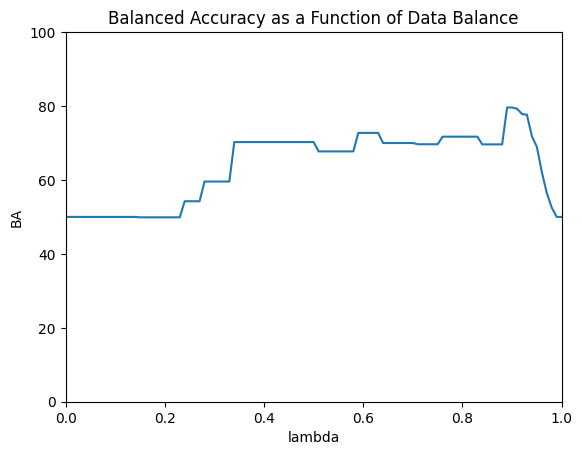

In [33]:
plt.plot(lam_list, BA_list)

# Add labels and title
plt.xlabel('lambda')
plt.ylabel('BA')
plt.xlim(0, 1)
plt.ylim(0, 100)
plt.title('Balanced Accuracy as a Function of Data Balance')

# Display the plot
plt.show()